# Preparation

This project aims on using Deep Learning with Kullback-Leibler Divergence. Some basic packages are required for this project. The aim of the following chunk is to install required packages such as `lifelines`, `sklearn-pandas` and `torchtuples`. Note that `pycox` is built based on `torchtuples`.

---

`pycox` should be pre-installed and removed into the google drive since we need to modify part of the code in this package for our model. However in the tutorial, we can actually predefine our loss function outside the package, so this part need to be updated probably.


In [1]:
!pwd
!pip install lifelines
! pip install sklearn-pandas
! pip install torchtuples
# ! pip install statsmodels
! pip install statsmodels --upgrade
# ! pip install pycox

/content
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 349 kB 12.4 MB/s 
     |████████████████████████████████| 68 kB 1.6 MB/s 
     |████████████████████████████████| 38.1 MB 1.5 MB/s 
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4048 sha256=c753c926d228457cb808b74a122ce8bc28a19c38352f316053760220b2ac9df8
  Stored in directory: /root/.cache/pip/wheels/9f/01/ee/1331593abb5725ff7d8c1333aee93a50a1c29d6ddda9665c9f
Successfully built autograd-gamma
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is inc

`pycox` is pre-installed in /content/drive/MyDrive/pycox, before that we need to track the data in google drive.

In [2]:
from google.colab import drive

drive.mount("/content/drive")

%cd "/content/drive/MyDrive/pycox"
# %pwd
# from pycox.models import LogisticHazard

Mounted at /content/drive
/content/drive/MyDrive/pycox


In [3]:
import os
import sys

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch # For building the networks 
import torchtuples as tt # Some useful functions

# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper 

from pycox.datasets import metabric
from pycox.datasets import support
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

In [4]:
np.random.seed(1234)
_ = torch.manual_seed(1234)

If you have mounted the data rightly, you should print out the list for files in given folder. For example, this will print out all files in `/content/drive/My Drive/Kevin He`

In [5]:
# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "Kevin He"
GOOGLE_DRIVE_PATH = os.path.join("/content/drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['Deep Learning with KL-divergence Real Data: Tutorial.ipynb', 'local_data.csv', 'prior_data.csv', 'local_data_2.csv', 'local_data_3.csv', 'prior_data_subset.csv', 'prior_data_subset_2.csv', 'prior_data_subset_3.csv', 'R-code.ipynb', 'local_data_together.csv', 'Untitled', 'Deep Learning with KL Divergence Non-linear Visualization.ipynb', 'Deep Learning with KL Divergence Simulation Image Data.ipynb', 'Deep Learning with KL Divergence.ipynb', 'Deep Learning with KL Divergence Real Data.ipynb', 'prior_data_subset_4.csv', 'Deep Learning with KL Divergence Simulation 1: Tutorial', 'Deep Learning with KL Divergence Simulation Non-linear-prop.ipynb', 'Deep Learning with KL Divergence Simulation 2-1: Tutorial.ipynb', 'Deep Learning with KL Divergence Simulation 3: Tutorial.ipynb']


# Data Preparation: SUPPORT

The Study to Understand Prognoses Preferences Out
comes and Risks of Treatment (SUPPORT) is a larger
study that researches the survival time of seriously ill
hospitalized adults. The dataset consists of 9,105
patients and 14 features for which almost all patients have
observed entries (age, sex, race, number of comorbidi
ties, presence of diabetes, presence of dementia, presence
of cancer, mean arterial blood pressure, heart rate, respi
ration rate, temperature, white blood cell count, serum’s
sodium, and serum’s creatinine). We drop patients with
any missing features and reserve 20 percent of the dataset
as a testing set. A total of 68.10 percent of patients died
during the survey with a median death time of 58 days.

In this dataset we abstract our features and we will generate a discrete time survival data with given time intervals.

In [ ]:
df_train = support.read_df()

In [ ]:
df_train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,30.0,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,1527.0,0
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,96.0,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,892.0,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868,81.064941,0.0,4.0,1.0,0.0,0.0,1.0,111.0,110.0,34.0,39.593750,135.0,13.000000,1.500000,36.0,1
8869,72.560966,0.0,2.0,1.0,0.0,0.0,1.0,53.0,74.0,28.0,34.695309,139.0,7.899414,1.899902,49.0,1
8870,63.228001,0.0,1.0,1.0,0.0,0.0,2.0,95.0,110.0,22.0,38.695309,132.0,7.799805,1.500000,6.0,1
8871,75.405937,0.0,2.0,1.0,1.0,0.0,2.0,109.0,110.0,30.0,36.195309,140.0,15.398438,0.899902,10.0,1


We want to generate 20 time intervals by grouping the continuous event time by quantiles. The cuts are defined by the whole dataset. We will cover the discrete time on the original continuous time, which means `duration` will be alternated by our discrete time $0, 1, 2, \ldots, 19$.

In [ ]:
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))

In [ ]:
y_train[0]

array([ 7, 18, 11, ...,  3,  4, 16])

You can see the boundaries for each time interval by `labtrans.cuts`.

In [ ]:
labtrans.cuts

array([   0.,    3.,    5.,    8.,   11.,   16.,   23.,   32.,   46.,
         66.,   95.,  138.,  195.,  268.,  380.,  533.,  754., 1027.,
       1387., 2029.], dtype=float32)

In [ ]:
df_train["duration"] = y_train[0]
df_train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
0,82.709961,1.0,2.0,1.0,0.0,0.0,0.0,160.0,55.0,16.0,38.195309,142.0,19.000000,1.099854,7,1
1,79.660950,1.0,0.0,1.0,0.0,0.0,1.0,54.0,67.0,16.0,38.000000,142.0,10.000000,0.899902,18,0
2,23.399990,1.0,2.0,3.0,0.0,0.0,1.0,87.0,144.0,45.0,37.296879,130.0,5.199219,1.199951,11,1
3,53.075989,1.0,4.0,3.0,0.0,0.0,0.0,55.0,100.0,18.0,36.000000,135.0,8.699219,0.799927,16,0
4,71.794983,0.0,1.0,1.0,0.0,0.0,0.0,65.0,135.0,40.0,38.593750,146.0,0.099991,0.399963,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868,81.064941,0.0,4.0,1.0,0.0,0.0,1.0,111.0,110.0,34.0,39.593750,135.0,13.000000,1.500000,8,1
8869,72.560966,0.0,2.0,1.0,0.0,0.0,1.0,53.0,74.0,28.0,34.695309,139.0,7.899414,1.899902,9,1
8870,63.228001,0.0,1.0,1.0,0.0,0.0,2.0,95.0,110.0,22.0,38.695309,132.0,7.799805,1.500000,3,1
8871,75.405937,0.0,2.0,1.0,1.0,0.0,2.0,109.0,110.0,30.0,36.195309,140.0,15.398438,0.899902,4,1


In [ ]:
df_train.groupby("duration").count()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,event
duration,,,,,,,,,,,,,,,
1,136,136,136,136,136,136,136,136,136,136,136,136,136,136,136
2,423,423,423,423,423,423,423,423,423,423,423,423,423,423,423
3,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471
4,322,322,322,322,322,322,322,322,322,322,322,322,322,322,322
5,352,352,352,352,352,352,352,352,352,352,352,352,352,352,352
6,410,410,410,410,410,410,410,410,410,410,410,410,410,410,410
7,365,365,365,365,365,365,365,365,365,365,365,365,365,365,365
8,349,349,349,349,349,349,349,349,349,349,349,349,349,349,349
9,357,357,357,357,357,357,357,357,357,357,357,357,357,357,357


We also need to deduct the time by 1 due to the implementation of LogisticHazard. Namely, in LogisticHazard, 0 is the starting time. But here the transformed time starts from 1.

In [ ]:
df_train['duration'] = df_train['duration'] - 1

Although for real data part, it seems really hard to find a "prior model", we can generate prior model by subseting most of the data and train a neural network (NN). After that we use the output of the NN (which are the hazard rates for each time interval) as prior information to compute `combined_info`. We also want to see whether our model can perform better when the ratio of local data varies.

In [ ]:
# Here ratio means that of prior data, which means 2% of the data is local data.
ratio = 0.98

df_prior = df_train.sample(frac = ratio)
df_local = df_train.drop(df_prior.index)

In [ ]:
df_local

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,duration,event
48,65.231987,0.0,0.0,1.0,0.0,0.0,1.0,57.0,145.0,24.0,36.398441,130.0,7.199219,1.399902,16,0
58,42.981991,0.0,3.0,1.0,0.0,0.0,1.0,58.0,134.0,40.0,39.093750,136.0,2.299805,3.699707,8,1
135,54.488979,0.0,1.0,1.0,0.0,0.0,1.0,108.0,58.0,10.0,36.296879,143.0,11.000000,1.199951,14,0
209,69.053963,1.0,5.0,1.0,1.0,0.0,2.0,67.0,91.0,34.0,38.398441,133.0,9.599609,1.099854,4,1
218,72.314941,1.0,3.0,1.0,1.0,0.0,1.0,64.0,111.0,8.0,38.195309,137.0,4.500000,0.599976,14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8699,48.924992,1.0,3.0,2.0,0.0,0.0,1.0,66.0,128.0,10.0,37.593750,138.0,10.298828,1.000000,1,1
8714,62.004002,0.0,0.0,1.0,0.0,0.0,1.0,134.0,107.0,20.0,36.195309,131.0,10.199219,1.599854,1,1
8746,66.931953,1.0,1.0,2.0,0.0,0.0,2.0,141.0,148.0,28.0,37.500000,142.0,22.296875,1.099854,18,0
8823,43.603001,1.0,3.0,1.0,1.0,0.0,1.0,70.0,176.0,20.0,37.898441,134.0,8.298828,0.799927,16,0


# Train Prior Model

Firstly we need to train a prior model, a NN with prior data as input and 20% of them is used for validation (early stopping). Note that we have categorical but not binary features in SUPPORT, wherer we need to make sure they are not affected by standardization. Moreover, we need to transfer them to `int64`. 

In [ ]:
# Only for simplicity and unity, nvm.

data_prior = df_prior.copy()

In [ ]:
data_prior_val = data_prior.sample(frac=0.2)
data_prior_train = data_prior.drop(data_prior_val.index)

In [ ]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical] # we need a separate mapper to ensure the data type 'int64'

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(data_prior_train)
x_val = x_transform(data_prior_val)

In [ ]:
x_val

(array([[ 0.4846944 ,  1.1611365 , -2.3653612 , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.3581172 ,  1.0895752 ,  0.48790774, ...,  1.        ,
          1.        ,  1.        ],
        [ 0.02275299,  1.0895752 , -0.70356715, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-1.145168  ,  1.1253558 ,  0.45655313, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.4754538 ,  0.30240193, -0.79763097, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.94542706,  0.40974376, -0.04512051, ...,  1.        ,
          0.        ,  0.        ]], dtype=float32), array([[2, 2, 1],
        [4, 3, 2],
        [5, 2, 2],
        ...,
        [2, 2, 1],
        [2, 2, 2],
        [3, 2, 1]]))

For `y_train` and `y_val`, you can use `get_target` function, which is used in tutorial for Simulation 1, to form the tuple for labels. But remember, do not use `labtrans.fit_transform` or `labtrans.transform` since we have pre-defined the cuts for time intervals before using the whole dataset and transformed the time from continuous to discrete. 

In [ ]:
# Caution: The data type for event times should be float32

get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
y_train = get_target(data_prior_train)
y_val = get_target(data_prior_val)

In [ ]:
train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

For the next step we need to build our deep learning model. Due to the existence of categorical features, we use embedding to do feature transformation for these features. The transformed features will be combined into other features and then served as input for main fully-connected neural network model.

We will also store `num_embeddings` and `embedding_dims` for the usage of output of this model when applying it on the local data.

In [ ]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

num_embeddings, embedding_dims

(array([8, 7, 4]), array([4, 3, 2]))

`net` shows the details of model structure.

In [ ]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features - 1
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

`AdamWR` is used here as the optimizer, it is an advanced version of Adam.

In [ ]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)
model.optimizer.set_lr(0.01)

batch_size = 256

In [ ]:
# For early stopping, we will use EarlyStoppingCycle which work in the same manner as EarlyStopping but will stop at the end of the cycle if the current best model was not obtained in the current cycle.

epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [ ]:
x_train

(array([[-1.2290816 ,  0.33818254, -0.67221254, ...,  0.        ,
          1.        ,  0.        ],
        [-2.3351963 ,  1.3758202 ,  0.5506169 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.2139619 , -0.34164897, -0.73492175, ...,  1.        ,
          0.        ,  0.        ],
        ...,
        [ 0.51973706,  1.304259  ,  0.70738995, ...,  0.        ,
          1.        ,  1.        ],
        [ 0.39345175, -0.48477137,  0.26842552, ...,  0.        ,
          1.        ,  0.        ],
        [-0.18744776,  0.6244273 ,  0.5192623 , ...,  0.        ,
          0.        ,  0.        ]], dtype=float32), array([[3, 2, 2],
        [3, 2, 3],
        [1, 2, 2],
        ...,
        [6, 2, 2],
        [6, 2, 2],
        [2, 2, 1]]))

In [ ]:
# %%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

0:	[0s / 0s],		train_loss: 7.1930,	val_loss: 6.0200
1:	[0s / 0s],		train_loss: 4.2476,	val_loss: 2.6667
2:	[0s / 0s],		train_loss: 2.6697,	val_loss: 2.5600
3:	[0s / 0s],		train_loss: 2.5771,	val_loss: 2.5279
4:	[0s / 0s],		train_loss: 2.5357,	val_loss: 2.5119
5:	[0s / 0s],		train_loss: 2.5151,	val_loss: 2.5094
6:	[0s / 0s],		train_loss: 2.5116,	val_loss: 2.5098
7:	[0s / 1s],		train_loss: 2.5182,	val_loss: 2.5023
8:	[0s / 1s],		train_loss: 2.5086,	val_loss: 2.4976
9:	[0s / 1s],		train_loss: 2.4849,	val_loss: 2.4881
10:	[0s / 1s],		train_loss: 2.4712,	val_loss: 2.4873
11:	[0s / 1s],		train_loss: 2.4569,	val_loss: 2.4851
12:	[0s / 1s],		train_loss: 2.4737,	val_loss: 2.4843
13:	[0s / 1s],		train_loss: 2.4638,	val_loss: 2.4839
14:	[0s / 1s],		train_loss: 2.4733,	val_loss: 2.4844
15:	[0s / 2s],		train_loss: 2.4575,	val_loss: 2.4811
16:	[0s / 2s],		train_loss: 2.4589,	val_loss: 2.4842
17:	[0s / 2s],		train_loss: 2.4621,	val_loss: 2.4803
18:	[0s / 2s],		train_loss: 2.4630,	val_loss: 2.4813
19:

# Apply Prior Model to Local

Similarly, we sample out training, validation and test data from local data. Note that we need to compute `combined_info` and send it into the model to compute our loss function.

In [ ]:
df_local = df_local.reset_index(drop = True)

In [ ]:
df_test = df_local.sample(frac=0.2)
df_train = df_local.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

`model.predict_hazard` is used for generating prior information. The number of columns should be the same as the number of time intervals.

In [ ]:
prior_info_train = model.predict_hazard(x_train)
prior_info_val = model.predict_hazard(x_val)

In [ ]:
prior_info_train.shape

(114, 20)

In [ ]:
data_local_train_index = np.array(df_train.index)
data_local_val_index = np.array(df_val.index)

In [ ]:
time = df_local["duration"]
time = np.array(time).reshape(time.shape[0], -1)
zeros = np.zeros((time.shape[0], 21)) # 21 - 1 = 20
np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
zeros = zeros[:, 1:]
zeros

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Similar as what shown in Simulation 1, we provide with one example to see whether `zeros` are generated right.

In [ ]:
df_train.loc[1, ["duration", 'event']]

duration    8.0
event       1.0
Name: 1, dtype: float64

In [ ]:
zeros[1,:]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [ ]:
zeros_train = zeros[data_local_train_index]
zeros_val = zeros[data_local_val_index]

In [ ]:
eta = 20
combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

# Training

We need to train a model for local data, but note that the embedding structure should be the same as prior model. 

In [ ]:
in_features = x_train[0].shape[1]
out_features = labtrans.out_features - 1
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
n_train = df_train.shape[0]
n_val = df_val.shape[0]

y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

durations_test, events_test = get_target(df_test)

In [ ]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, loss = "option")

batch_size = 100

epochs = 300
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

1


In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 8.6489,	val_loss: 8.1654
1:	[0s / 0s],		train_loss: 8.6963,	val_loss: 8.0144
2:	[0s / 0s],		train_loss: 8.3463,	val_loss: 7.9353
3:	[0s / 0s],		train_loss: 8.4258,	val_loss: 7.7250
4:	[0s / 0s],		train_loss: 7.9131,	val_loss: 7.5066
5:	[0s / 0s],		train_loss: 7.8767,	val_loss: 7.4449
6:	[0s / 0s],		train_loss: 7.7759,	val_loss: 7.4335
7:	[0s / 0s],		train_loss: 8.5942,	val_loss: 7.2464
8:	[0s / 0s],		train_loss: 7.7306,	val_loss: 7.1361
9:	[0s / 0s],		train_loss: 7.9248,	val_loss: 7.0281
10:	[0s / 0s],		train_loss: 7.3829,	val_loss: 6.9373
11:	[0s / 0s],		train_loss: 7.9618,	val_loss: 6.9015
12:	[0s / 0s],		train_loss: 8.1572,	val_loss: 6.8885
13:	[0s / 0s],		train_loss: 7.3023,	val_loss: 6.9042
14:	[0s / 0s],		train_loss: 7.1843,	val_loss: 6.9295
15:	[0s / 0s],		train_loss: 7.4118,	val_loss: 6.8376
16:	[0s / 0s],		train_loss: 7.1728,	val_loss: 6.6789
17:	[0s / 0s],		train_loss: 7.4726,	val_loss: 6.5528
18:	[0s / 0s],		train_loss: 6.8042,	val_loss: 6.4067
19:

# Evaluation

In [ ]:
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td('antolini')

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


0.5402061855670103

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [ ]:
ev.integrated_brier_score(time_grid)

0.21605143814587047

In [ ]:
ev.integrated_nbll(time_grid)

0.6253720576977547

# Baseline: LogisticHazard

For baseline model, we only use the local data. 

In [ ]:
df_test = df_local.sample(frac=0.2)
df_train = df_local.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [ ]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

In [ ]:
num_durations = 20
scheme = 'quantiles'
# labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
y_train = get_target(df_train)
y_val = get_target(df_val)

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

durations_test, events_test = get_target(df_test)

In [ ]:
in_features = x_train[0].shape[1]
out_features = 20
num_nodes = [32, 32, 32]
batch_norm = True
dropout = 0.2

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

net

MixedInputMLP(
  (embeddings): EntityEmbeddings(
    (embeddings): ModuleList(
      (0): Embedding(8, 4)
      (1): Embedding(7, 3)
      (2): Embedding(4, 2)
    )
  )
  (mlp): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=20, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (2): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer)

batch_size = 20

# For early stopping, we will use EarlyStoppingCycle which work in the same manner as EarlyStopping but will stop at the end of the cycle if the current best model was not obtained in the current cycle.

epochs = 300
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
y_train

(array([16,  8,  4,  6, 17,  2,  4,  6, 11, 16, 18, 11, 12,  2, 19, 14, 15,
        10,  8, 11, 13, 11,  2, 14,  4, 11, 15, 16, 13, 14, 14, 13, 12, 14,
        16, 16, 15,  3, 14, 16, 18, 14, 17, 16, 18,  4,  4, 10, 15, 15,  7,
        12, 10, 16, 12, 11, 18, 14, 16,  8,  1,  1, 16,  7, 12, 15,  2,  0,
        17, 14, 15, 15,  0, 12, 18, 13,  6, 18, 18, 18, 15, 16, 14, 16, 12,
        14, 13, 16, 18,  4, 15, 18, 15, 15, 18, 12, 18, 11, 15, 18, 13, 18,
        15, 16,  3, 16,  1,  2,  8, 16,  1,  1, 18, 17]),
 array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 1.

In [ ]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[0s / 0s],		train_loss: 9.2785,	val_loss: 6.9044
1:	[0s / 0s],		train_loss: 8.6473,	val_loss: 6.5239
2:	[0s / 0s],		train_loss: 8.1910,	val_loss: 6.3545
3:	[0s / 0s],		train_loss: 7.8883,	val_loss: 5.9611
4:	[0s / 0s],		train_loss: 7.1740,	val_loss: 5.7473
5:	[0s / 0s],		train_loss: 6.9670,	val_loss: 5.6288
6:	[0s / 0s],		train_loss: 6.5078,	val_loss: 5.5878
7:	[0s / 0s],		train_loss: 6.1784,	val_loss: 5.0547
8:	[0s / 0s],		train_loss: 5.8991,	val_loss: 4.4993
9:	[0s / 0s],		train_loss: 5.3381,	val_loss: 4.0784
10:	[0s / 0s],		train_loss: 4.6421,	val_loss: 3.7728
11:	[0s / 0s],		train_loss: 4.1597,	val_loss: 3.5975
12:	[0s / 0s],		train_loss: 4.0366,	val_loss: 3.4978
13:	[0s / 0s],		train_loss: 3.9562,	val_loss: 3.4686
14:	[0s / 0s],		train_loss: 3.9729,	val_loss: 3.4786
15:	[0s / 0s],		train_loss: 3.5723,	val_loss: 3.2807
16:	[0s / 0s],		train_loss: 3.1466,	val_loss: 3.1189
17:	[0s / 0s],		train_loss: 2.9139,	val_loss: 3.0071
18:	[0s / 0s],		train_loss: 2.6216,	val_loss: 2.9267
19:

In [ ]:
surv = model.predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td('antolini')

0.5029013539651838

In [ ]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)

In [ ]:
ev.integrated_brier_score(time_grid)

0.2322114237739915

In [ ]:
ev.integrated_nbll(time_grid)

0.6613552988359802

# Combination: Multiple Experiments

In this experiment, we would like to see the trend for our model when we vary the ratio of local data. In general our model should always be better than other models, but the difference will be smaller and smaller when the size of local data increases.

In [6]:
concordance_td_list_98 = []
integrated_brier_score_list_98 = []
integrated_nbll_list_98 = []
concordance_td_list_old_98 = []
integrated_brier_score_list_old_98 = []
integrated_nbll_list_old_98 = []

ratio = 0.98
for i in range(20):
  df_train = support.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  # df_train["duration"] = df_train["duration"] - 1

  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)
  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical) 
  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(data_prior_train)
  x_val = x_transform(data_prior_val)

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  num_embeddings = x_train[1].max(0) + 1
  embedding_dims = num_embeddings // 2

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2
  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer)
  batch_size = 256
  model.optimizer.set_lr(0.01)

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(df_train)
  x_val = x_transform(df_val)
  x_test = x_transform(df_test)

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  # num_embeddings = x_train[1].max(0) + 1
  # embedding_dims = num_embeddings // 2
  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer, loss = "option")

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout
  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_98.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_98.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_98.append((ev.integrated_nbll(time_grid)))

  num_durations = 20
  scheme = 'quantiles'

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                  num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                              cycle_multiplier=2)
  model = LogisticHazard(net, optimizer)

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  model.optimizer.set_lr(0.01)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_98.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_98.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_98.append(ev.integrated_nbll(time_grid))

/usr/local/lib/python3.7/dist-packages/torchtuples/callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)
  p.data = p.data.add(-weight_decay * eta, p.data)


1


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

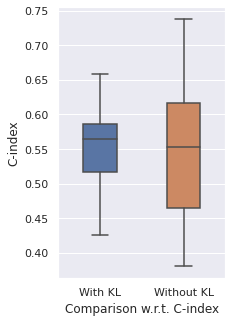

In [7]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_98)
concordance_td_array_old = np.array(concordance_td_list_old_98)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_98)
integrated_brier_score_array = np.array(integrated_brier_score_list_98)
integrated_nbll_array = np.array(integrated_nbll_list_98)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_98)

data = np.array(concordance_td_list_98 + concordance_td_list_old_98)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


In [8]:
concordance_td_list_95 = []
integrated_brier_score_list_95 = []
integrated_nbll_list_95 = []
concordance_td_list_old_95 = []
integrated_brier_score_list_old_95 = []
integrated_nbll_list_old_95 = []

ratio = 0.95
for i in range(20):
  df_train = support.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)
  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical) 
  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(data_prior_train)
  x_val = x_transform(data_prior_val)

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  num_embeddings = x_train[1].max(0) + 1
  embedding_dims = num_embeddings // 2

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2
  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer)
  batch_size = 256
  model.optimizer.set_lr(0.01)

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(df_train)
  x_val = x_transform(df_val)
  x_test = x_transform(df_test)

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  # num_embeddings = x_train[1].max(0) + 1
  # embedding_dims = num_embeddings // 2
  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer, loss = "option")

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout
  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_95.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_95.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_95.append((ev.integrated_nbll(time_grid)))

  num_durations = 20
  scheme = 'quantiles'

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                  num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                              cycle_multiplier=2)
  model = LogisticHazard(net, optimizer)

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  model.optimizer.set_lr(0.01)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_95.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_95.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_95.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

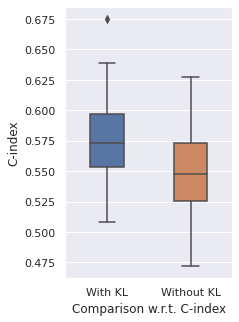

In [9]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_95)
concordance_td_array_old = np.array(concordance_td_list_old_95)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_95)
integrated_brier_score_array = np.array(integrated_brier_score_list_95)
integrated_nbll_array = np.array(integrated_nbll_list_95)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_95)

data = np.array(concordance_td_list_95 + concordance_td_list_old_95)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


In [10]:
concordance_td_list_90 = []
integrated_brier_score_list_90 = []
integrated_nbll_list_90 = []
concordance_td_list_old_90 = []
integrated_brier_score_list_old_90 = []
integrated_nbll_list_old_90 = []

ratio = 0.9
for i in range(20):
  df_train = support.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)
  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical) 
  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(data_prior_train)
  x_val = x_transform(data_prior_val)

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  num_embeddings = x_train[1].max(0) + 1
  embedding_dims = num_embeddings // 2

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2
  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer)
  batch_size = 256
  model.optimizer.set_lr(0.01)

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(df_train)
  x_val = x_transform(df_val)
  x_test = x_transform(df_test)

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  # num_embeddings = x_train[1].max(0) + 1
  # embedding_dims = num_embeddings // 2
  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer, loss = "option")

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout
  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_90.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_90.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_90.append((ev.integrated_nbll(time_grid)))

  num_durations = 20
  scheme = 'quantiles'

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                  num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                              cycle_multiplier=2)
  model = LogisticHazard(net, optimizer)

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  model.optimizer.set_lr(0.01)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_90.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_90.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_90.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

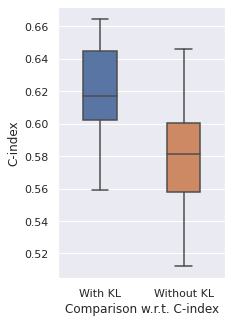

In [11]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_90)
concordance_td_array_old = np.array(concordance_td_list_old_90)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_90)
integrated_brier_score_array = np.array(integrated_brier_score_list_90)
integrated_nbll_array = np.array(integrated_nbll_list_90)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_90)

data = np.array(concordance_td_list_90 + concordance_td_list_old_90)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


In [12]:
concordance_td_list_80 = []
integrated_brier_score_list_80 = []
integrated_nbll_list_80 = []
concordance_td_list_old_80 = []
integrated_brier_score_list_old_80 = []
integrated_nbll_list_old_80 = []

ratio = 0.8
for i in range(20):
  df_train = support.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)
  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical) 
  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(data_prior_train)
  x_val = x_transform(data_prior_val)

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  num_embeddings = x_train[1].max(0) + 1
  embedding_dims = num_embeddings // 2

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2
  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer)
  batch_size = 256
  model.optimizer.set_lr(0.01)

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
  cols_leave = ['x1', 'x4', 'x5']
  cols_categorical =  ['x2', 'x3', 'x6']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]
  categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

  x_mapper_float = DataFrameMapper(standardize + leave)
  x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'

  x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
  x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))

  x_train = x_fit_transform(df_train)
  x_val = x_transform(df_val)
  x_test = x_transform(df_test)

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  # num_embeddings = x_train[1].max(0) + 1
  # embedding_dims = num_embeddings // 2
  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims, num_nodes, out_features, batch_norm, dropout)

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8, cycle_multiplier=2)

  model = LogisticHazard(net, optimizer, loss = "option")

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout
  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_80.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_80.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_80.append((ev.integrated_nbll(time_grid)))

  num_durations = 20
  scheme = 'quantiles'

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train[0].shape[1]
  out_features = labtrans.out_features
  num_nodes = [32, 32, 32]
  batch_norm = True
  dropout = 0.2

  net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                  num_nodes, out_features, batch_norm, dropout)

  optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                              cycle_multiplier=2)
  model = LogisticHazard(net, optimizer)

  batch_size = 20

  epochs = 300
  callbacks = [tt.cb.EarlyStoppingCycle()]
  verbose = False # set to True if you want printout

  model.optimizer.set_lr(0.01)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_80.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_80.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_80.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

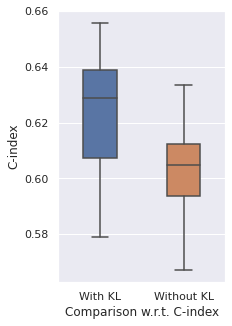

In [13]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_80)
concordance_td_array_old = np.array(concordance_td_list_old_80)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_80)
integrated_brier_score_array = np.array(integrated_brier_score_list_80)
integrated_nbll_array = np.array(integrated_nbll_list_80)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_80)

data = np.array(concordance_td_list_80 + concordance_td_list_old_80)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


We combine these results into one graph to see the trend.

120

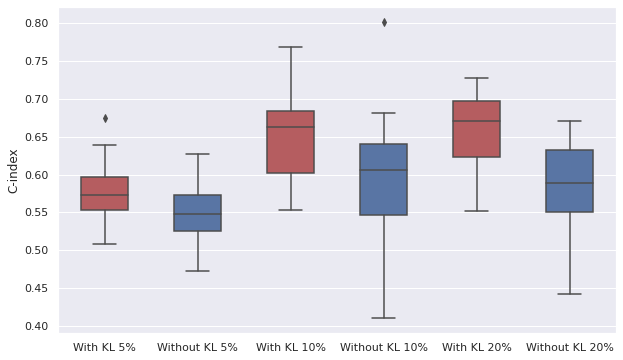

In [25]:
data = np.array(concordance_td_list_95 + concordance_td_list_old_95 + concordance_td_list_90 + concordance_td_list_old_90 + concordance_td_list_80 + concordance_td_list_old_80)
label = ["With KL 5%" for i in range(len(concordance_td_array))] + ["Without KL 5%" for i in range(len(concordance_td_array))] + ["With KL 10%" for i in range(len(concordance_td_array))] + ["Without KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL 20%" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.5, palette = ["r", "b", "r", "b", "r", "b"]).set(xlabel=None)#.set(title = "Comparison w.r.t. IBLL")
len(data)



120

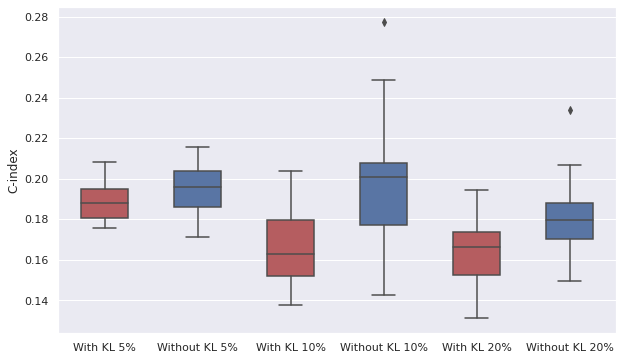

In [24]:
data = np.array(integrated_brier_score_list_95 + integrated_brier_score_list_old_95 + integrated_brier_score_list_90 + integrated_brier_score_list_old_90 + integrated_brier_score_list_80 + integrated_brier_score_list_old_80)
label = ["With KL 5%" for i in range(len(concordance_td_array))] + ["Without KL 5%" for i in range(len(concordance_td_array))] + ["With KL 10%" for i in range(len(concordance_td_array))] + ["Without KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL 20%" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.5, palette = ["r", "b", "r", "b", "r", "b"]).set(xlabel=None)#.set(title = "Comparison w.r.t. IBLL")
len(data)



# Other data: METABRIC

We also want to show the results for METABRIC data. Note that the covariates of this dataset have different properties, so the data pre-processing procedures are not the same.

In [ ]:
df_train = metabric.read_df()

num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
df_train["duration"] = y_train[0]

In [ ]:
df_train.groupby(['duration']).count()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,event
duration,,,,,,,,,,
0,24,24,24,24,24,24,24,24,24,24
1,112,112,112,112,112,112,112,112,112,112
2,103,103,103,103,103,103,103,103,103,103
3,107,107,107,107,107,107,107,107,107,107
4,150,150,150,150,150,150,150,150,150,150
5,137,137,137,137,137,137,137,137,137,137
6,143,143,143,143,143,143,143,143,143,143
7,169,169,169,169,169,169,169,169,169,169
8,166,166,166,166,166,166,166,166,166,166


In [16]:
concordance_td_list_90 = []
integrated_brier_score_list_90 = []
integrated_nbll_list_90 = []
concordance_td_list_old_90 = []
integrated_brier_score_list_old_90 = []
integrated_nbll_list_old_90 = []

ratio = 0.9
for i in range(20):
  df_train = metabric.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  # df_train['duration'] = df_train['duration'] - 1
  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(data_prior_train).astype('float32')
  x_val = x_mapper.transform(data_prior_val).astype('float32')
  # x_test = x_mapper.transform(df_test).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 64
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(df_train).astype('float32')
  x_val = x_mapper.transform(df_val).astype('float32')
  x_test = x_mapper.transform(df_test).astype('float32')

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), loss = "option")

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)
  
  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_90.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_90.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_90.append((ev.integrated_nbll(time_grid)))

  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_90.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_90.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_90.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

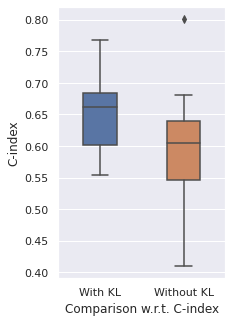

In [17]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_90)
concordance_td_array_old = np.array(concordance_td_list_old_90)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_90)
integrated_brier_score_array = np.array(integrated_brier_score_list_90)
integrated_nbll_array = np.array(integrated_nbll_list_90)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_90)

data = np.array(concordance_td_list_90 + concordance_td_list_old_90)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


In [18]:
concordance_td_list_80 = []
integrated_brier_score_list_80 = []
integrated_nbll_list_80 = []
concordance_td_list_old_80 = []
integrated_brier_score_list_old_80 = []
integrated_nbll_list_old_80 = []

ratio = 0.8
for i in range(20):
  df_train = metabric.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  # df_train['duration'] = df_train['duration'] - 1
  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(data_prior_train).astype('float32')
  x_val = x_mapper.transform(data_prior_val).astype('float32')
  # x_test = x_mapper.transform(df_test).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 64
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(df_train).astype('float32')
  x_val = x_mapper.transform(df_val).astype('float32')
  x_test = x_mapper.transform(df_test).astype('float32')

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), loss = "option")

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)
  
  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_80.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_80.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_80.append((ev.integrated_nbll(time_grid)))

  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_80.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_80.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_80.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

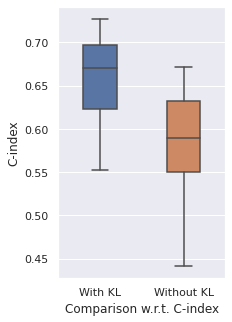

In [19]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_80)
concordance_td_array_old = np.array(concordance_td_list_old_80)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_80)
integrated_brier_score_array = np.array(integrated_brier_score_list_80)
integrated_nbll_array = np.array(integrated_nbll_list_80)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_80)

data = np.array(concordance_td_list_80 + concordance_td_list_old_80)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


In [20]:
concordance_td_list_70 = []
integrated_brier_score_list_70 = []
integrated_nbll_list_70 = []
concordance_td_list_old_70 = []
integrated_brier_score_list_old_70 = []
integrated_nbll_list_old_70 = []

ratio = 0.7
for i in range(20):
  df_train = metabric.read_df()

  num_durations = 20
  scheme = 'quantiles'
  labtrans = LogisticHazard.label_transform(num_durations, scheme)

  get_target = lambda df: (df['duration'].values, df['event'].values)
  y_train = labtrans.fit_transform(*get_target(df_train))
  df_train["duration"] = y_train[0]

  # df_train['duration'] = df_train['duration'] - 1
  df_prior = df_train.sample(frac = ratio)
  df_local = df_train.drop(df_prior.index)

  data_prior = df_prior.copy()
  data_prior_val = data_prior.sample(frac=0.2)
  data_prior_train = data_prior.drop(data_prior_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(data_prior_train).astype('float32')
  x_val = x_mapper.transform(data_prior_val).astype('float32')
  # x_test = x_mapper.transform(df_test).astype('float32')

  get_target = lambda df: (df['duration'].values, np.array(df['event'].values, dtype = np.float32))
  y_train = get_target(data_prior_train)
  y_val = get_target(data_prior_val)
  # durations_test, events_test = get_target(df_test)
  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 64
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)

  df_local = df_local.reset_index(drop = True)
  df_test = df_local.sample(frac=0.2)
  df_train = df_local.drop(df_test.index)
  df_val = df_train.sample(frac=0.2)
  df_train = df_train.drop(df_val.index)

  cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x8']
  cols_leave = ['x4', 'x5', 'x6', 'x7']

  standardize = [([col], StandardScaler()) for col in cols_standardize]
  leave = [(col, None) for col in cols_leave]

  x_mapper = DataFrameMapper(standardize + leave)
  x_train = x_mapper.fit_transform(df_train).astype('float32')
  x_val = x_mapper.transform(df_val).astype('float32')
  x_test = x_mapper.transform(df_test).astype('float32')

  prior_info_train = model.predict_hazard(x_train)
  prior_info_val = model.predict_hazard(x_val)
  data_local_train_index = np.array(df_train.index)
  data_local_val_index = np.array(df_val.index)

  time = df_local["duration"]
  time = np.array(time).reshape(time.shape[0], -1)
  zeros = np.zeros((time.shape[0], 21))
  np.put_along_axis(zeros, time, np.array(df_local["event"]).reshape(-1, 1), axis=1)
  zeros = zeros[:, :-1]

  zeros_train = zeros[data_local_train_index]
  zeros_val = zeros[data_local_val_index]

  eta = 20
  combined_info_train = (zeros_train + eta * prior_info_train) / (1 + eta)
  combined_info_val = (zeros_val + eta * prior_info_val) / (1 + eta)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01), loss = "option")

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  n_train = df_train.shape[0]
  n_val = df_val.shape[0]
  y_train = (combined_info_train, df_train['duration'].values, df_train['event'].values)
  y_val = (combined_info_val, df_val['duration'].values, df_val['event'].values)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose, val_data=val)
  
  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_70.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_70.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_70.append((ev.integrated_nbll(time_grid)))

  y_train = get_target(df_train)
  y_val = get_target(df_val)

  train = tt.tuplefy(x_train, y_train)
  val = tt.tuplefy(x_val, y_val)

  durations_test, events_test = get_target(df_test)

  in_features = x_train.shape[1]
  num_nodes = [32, 32]
  out_features = labtrans.out_features
  batch_norm = True
  dropout = 0.1

  net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

  model = LogisticHazard(net, tt.optim.Adam(0.01))

  batch_size = 20
  epochs = 100
  callbacks = [tt.cb.EarlyStopping()]
  verbose = False # set to True if you want printout

  log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                  val_data=val)

  surv = model.predict_surv_df(x_test)
  ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

  concordance_td_list_old_70.append(ev.concordance_td('antolini'))
  time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
  integrated_brier_score_list_old_70.append(ev.integrated_brier_score(time_grid))
  integrated_nbll_list_old_70.append(ev.integrated_nbll(time_grid))

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


40

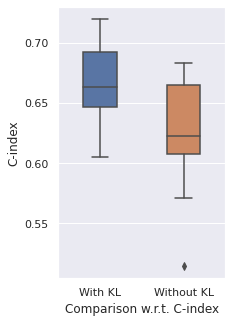

In [21]:
import seaborn as sns

concordance_td_array = np.array(concordance_td_list_70)
concordance_td_array_old = np.array(concordance_td_list_old_70)
integrated_brier_score_array_old = np.array(integrated_brier_score_list_old_70)
integrated_brier_score_array = np.array(integrated_brier_score_list_70)
integrated_nbll_array = np.array(integrated_nbll_list_70)
integrated_nbll_array_old = np.array(integrated_nbll_list_old_70)

data = np.array(concordance_td_list_70 + concordance_td_list_old_70)
label = ["With KL" for i in range(len(concordance_td_array))] + ["Without KL" for i in range(len(concordance_td_array_old))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t. C-index": label})

sns.set(rc={'figure.figsize':(3,5)})
sns.boxplot(x='Comparison w.r.t. C-index', y='C-index', data=df, width = 0.4)#.set(title = "Comparison w.r.t. IBLL")
len(data)


120

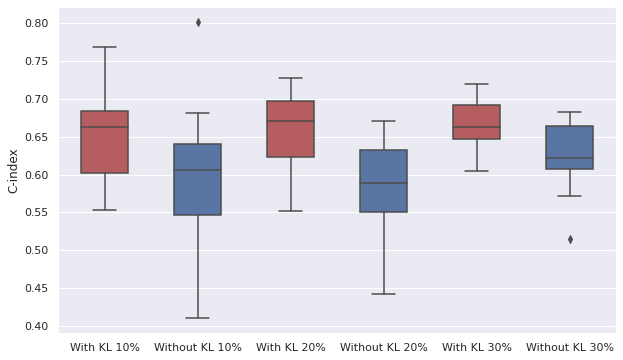

In [22]:
data = np.array(concordance_td_list_90 + concordance_td_list_old_90 + concordance_td_list_80 + concordance_td_list_old_80 + concordance_td_list_70 + concordance_td_list_old_70)
label = ["With KL 10%" for i in range(len(concordance_td_array))] + ["Without KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL 20%" for i in range(len(concordance_td_array))] + ["With KL 30%" for i in range(len(concordance_td_array))] + ["Without KL 30%" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.5, palette = ["r", "b", "r", "b", "r", "b"]).set(xlabel=None)#.set(title = "Comparison w.r.t. IBLL")
len(data)



120

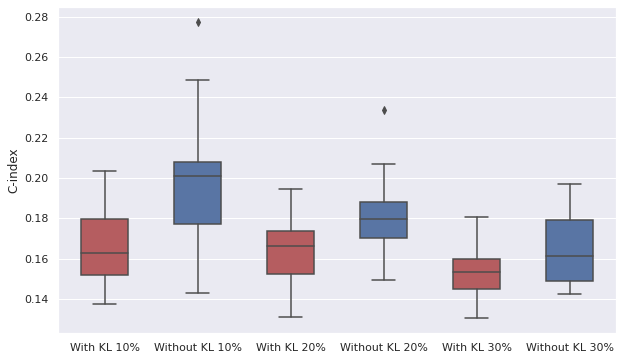

In [23]:
data = np.array(integrated_brier_score_list_90 + integrated_brier_score_list_old_90 + integrated_brier_score_list_80 + integrated_brier_score_list_old_80 + integrated_brier_score_list_70 + integrated_brier_score_list_old_70)
label = ["With KL 10%" for i in range(len(concordance_td_array))] + ["Without KL 10%" for i in range(len(concordance_td_array))] + ["With KL 20%" for i in range(len(concordance_td_array))] + ["Without KL 20%" for i in range(len(concordance_td_array))] + ["With KL 30%" for i in range(len(concordance_td_array))] + ["Without KL 30%" for i in range(len(concordance_td_array))]
df = pd.DataFrame({"C-index": data, "Comparison w.r.t C-index": label})

sns.set(rc={'figure.figsize':(10,6)})
sns.boxplot(x='Comparison w.r.t C-index', y='C-index', data=df, width = 0.5, palette = ["r", "b", "r", "b", "r", "b"]).set(xlabel=None)#.set(title = "Comparison w.r.t. IBLL")
len(data)

